# Exercise 4: U-Net for image segmentation

In this exercise we want to implement a U-Net for image segmentation from lecture 2.
U-Net is a convolutional neural network architecture designed for image segmentation, particularly in biomedical applications. It consists of two parts
1. Encoder (contracting path): Captures context through convolution and pooling layers, reducing spatial dimensions.
2. Decoder (expanding path): Restores spatial resolution using upsampling and combines it with corresponding encoder features via skip connections.

We will segment images from the OxfordIIIPet Dataset, which contains images of different cats and dogs. More specifically, we will segment them into three parts. For each pixel the U-Net should predict if it is background the border of the pet or inside the pet. An example can be seen in the image below.

<p align="center">
<img src="example.png" alt="example-pet" width="600"/>
</p>

In [1]:
# import the necessary packages
import os
from os import listdir
from os.path import isfile, join, splitext
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np
import torch
from PIL import Image
import torch
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
import utils
from oxford_pet_wrapper import OxfordPetDataset
from IPython.display import clear_output

## Configurations
In the following cell you can see all the configurations we later use for training the U-net. Feel free to change the hyperparameters and see how they influence training. If you want to see if your code works, without performing a long training, you can also lower the number of epochs.

In [2]:
MODEL_CHECKPOINT_DIR = "model_weights"
# define the validation percentage
VAL_PERCENT = 0.1
# batch size for training
BATCH_SIZE = 32
# learning rate for the optimizer
LEARNING_RATE = 1e-5
# momentum for the optimizer
MOMENTUM = 0.999
# gradient clipping value (for stability while training)
GRADIENT_CLIPPING = 1.0
# weight decay (L2 regularization) for the optimizer
WEIGHT_DECAY = 1e-8
# number of epochs for training
EPOCHS = 100
# set device to 'cuda' if CUDA is available, 'cpu' otherwise for model training and testing
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# Data Preperations

In our task we will segment images from the OxfordPetIII Dataset, which contains pictures of different dogs and cats, as well as their segmentation masks. For this we first fetch the data from the internet using PyTorch. Then we preprocess the data to make it usable for our task.

First of all, the images in the dataset can have different sizes, while the U-net expects inputs of the same size. Thus, we have to resize the images and their segmentation masks. Moreover, we have to normalize the images, and change the mask to mirror our three classes: background, pet, and border.

In [3]:
# create parent folder to store all the results
if not os.path.exists("output"):
    os.makedirs("output")

print("[INFO] Fetching the Oxford IIIT Pet Dataset from cache or downloading it")
# load the dataset
dataset = datasets.OxfordIIITPet(
    root="data", target_types="segmentation", download=True
)
# define the paths to the images and segmentation maps directories
images_dir = "./data/oxford-iiit-pet/images"
mask_dir = "./data/oxford-iiit-pet/annotations/trimaps"
print("[INFO] Preparing the dataset for training")
# initialize the OxfordPetDataset class
dataset = OxfordPetDataset(images_dir=images_dir, mask_dir=mask_dir)
# split into train / validation partitions
n_val = int(len(dataset) * VAL_PERCENT)
n_train = len(dataset) - n_val
train_set, val_set = random_split(
    dataset, [n_train, n_val], generator=torch.Generator().manual_seed(0)
)
# create data loaders for training and validation
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(
    val_set, batch_size=BATCH_SIZE, shuffle=False, drop_last=True
)

[INFO] Fetching the Oxford IIIT Pet Dataset from cache or downloading it
[INFO] Preparing the dataset for training
[INFO] Creating dataset with 7381 examples


100%|██████████| 7381/7381 [04:00<00:00, 30.63it/s]

[INFO] Unique mask values: [1, 2, 3]


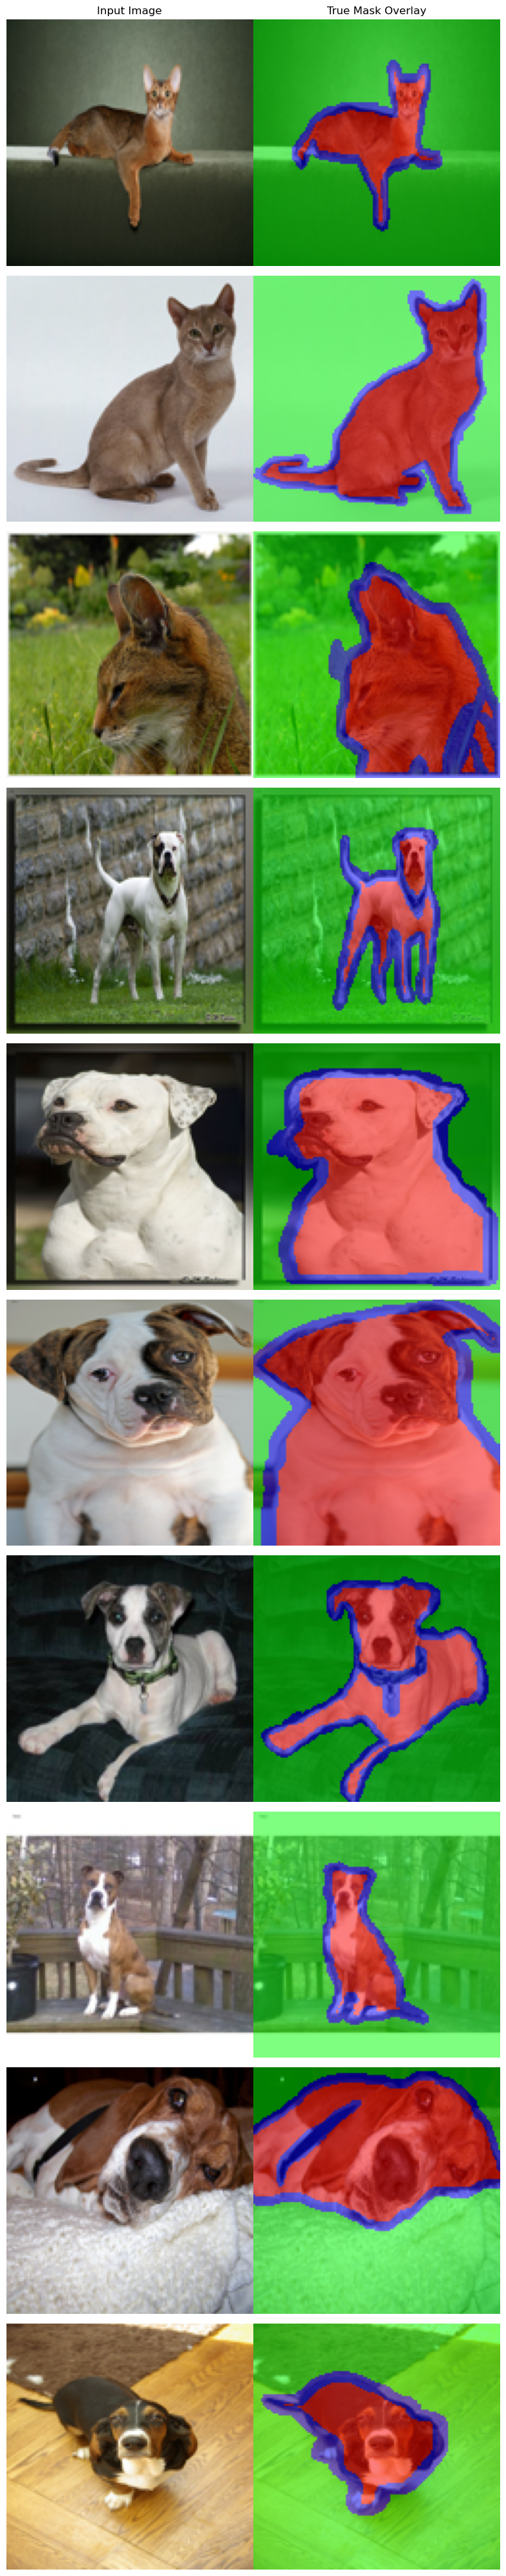

In [4]:
# visualize data
def overlay_multiclass_mask(image, mask, class_colors, alpha=0.5):
            """
            Overlay multi-class mask on image.
            - image: H x W x 3 float image (0-1)
            - mask: H x W int mask with values 0..N classes
            - class_colors: dict[class_value] = (r,g,b)
            - alpha: transparency for all classes
            Returns an image with overlays.
            """
            overlay = image.copy()
            for class_val, color in class_colors.items():
                class_mask = (mask == class_val)
                color_arr = np.array(color).reshape(1, 1, 3)
                class_mask_3d = np.repeat(class_mask[:, :, np.newaxis], 3, axis=2)
                overlay = np.where(
                    class_mask_3d,
                    (1 - alpha) * overlay + alpha * color_arr,
                    overlay)
            return overlay

class_colors = {
    0: (1, 0, 0),  # background red
    1: (0, 1, 0),  # pet green
    2: (0, 0, 1),  # border blue
}

fig, axs = plt.subplots(10, 2, figsize=(8, 40))

for i in range(10):
    idx = i * 80
    sample_image = dataset[idx]['image'].detach().cpu().numpy()
    sample_image = sample_image.transpose(1, 2, 0)
    sample_true_mask = dataset[idx]['mask'].detach().cpu().numpy()
    true_overlay = overlay_multiclass_mask(sample_image, sample_true_mask, class_colors, alpha=0.5)
    axs[i, 0].imshow(sample_image)
    axs[i, 0].axis("off")
    axs[i, 1].imshow(true_overlay)
    axs[i, 1].axis("off")
    if i == 0:
        axs[i, 0].set_title("Input Image")
        axs[i, 1].set_title("True Mask Overlay")
plt.tight_layout()
plt.show()

## 4.1. Implement the network architecture
Now its your task to implement the U-net for segmentation. Below you can see a visualization of the U-net we want to implement. You can see that it consists of two main parts. The first part is the contraction part, also named encoder, in which the input is gradually downsampled to extract fine-to-coarse features. The second part is the expansion part, also named decoder, in which the transposed convolution is used to upsample the features and reconstruct the segmentation mask from them. Different to an autoencoder for example, here we also have skip connections between the levels of equal ouput height and width, to directly  use the features of each level in the reconstruction of the segmentation mask.

In the visualization you can see the the number of channels as the number above each layer. And the size of the features as the tuple (axa) before each level.

<p align="center">
<img src="U_net.png" alt="u-net" width="1000"/>
</p>

a) Looking at the network architecture, we can see a recurring pattern. In each level we have two 2D convolutions with filter-size 3x3, and padding 1, each followed by a batch normalization and ReLU activation function. Because, we will reuse it throughout the whole network, lets first implement this block.

<p align="center">
<img src="U_net-convs.png" alt="dualconv"/>
</p>

In [24]:
class DualConv(nn.Module):
    def __init__(self, input_ch, output_ch):
        super(DualConv, self).__init__()

        # TODO: implement the two convolutions 
        # each followed by a batch normalization and ReLU activation
        self.conv_block = nn.Sequential(
            nn.Conv2d(input_ch, output_ch, 3, padding=1, bias=False),
            nn.BatchNorm2d(output_ch),
            nn.ReLU(),
            nn.Conv2d(output_ch, output_ch, 3, padding=1, bias=False),
            nn.BatchNorm2d(output_ch),
            nn.ReLU(),
        )
    def forward(self, x):
        # TODO: implement the forward pass
        return self.conv_block(x)

b) Lets now look at the contraction part. Here we also have recurring patterns, one of which is framed turquoise in the visualization below. For each contraction, the input is first downsampled using max pooling, and then features at this next coarser level are extracted using two 2D convolutions. 
Implement one contraction, reusing the class ```DualConv``` you implemented in (a).

<p align="center">
<img src="U_net-encoder.png" alt="unet-encoder" height="500"/>
</p>

In [ ]:
class Contract(nn.Module):
    def __init__(self, input_ch, output_ch):
        super(Contract, self).__init__()

        # TODO: implement a single contraction
        self.down_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DualConv(input_ch, output_ch)
        )
        
    def forward(self, x):
         # TODO: implement the forward pass
        return self.down_conv(x)

c) Analogously to the one contraction, we implemented in (b), lets now impelement one expansion block. Here, we first upsample using the Transposed Convolution. The transposed convolution should half the number of input channels and double the feature size. For this, we use a 2x2 kernel and a stride of 2. To get a better intuition of what this does, you can also look at the following visualization [here](https://github.com/vdumoulin/conv_arithmetic/blob/master/README.md). After upsampling again two 2D convolutions are applied, for which we can reuse the class ```DualConv```.
When looking at the skeleton code below, you might realize that the forward method, gets two inputs ```x1``` and ```x2```. This is because we have the skip connections as a second input to the block.

<p align="center">
<img src="U_net-decoder.png" alt="unet-decoder" height="500"/>
</p>

Below a visualization of the transposed convolution with a stride of 2. Notice that the stride is not applied on the input channel, but rather when creating the outpu.

<p align="center">
<img src="ConvTransposed.png" alt="Trasnposed Convolution with stride 2" height="400"/>
</p>

In [27]:
class Expand(nn.Module):
    def __init__(self, input_ch, output_ch):
        super(Expand, self).__init__()
        # TODO: impelement a single expansion
        self.up = nn.ConvTranspose2d(input_ch, input_ch // 2, kernel_size=2, stride=2)
        self.conv = DualConv(input_ch, output_ch)
    def forward(self, x1, x2):
        # TODO: implement the forward pass
        # x1 is the input from the lower level to be upsampled
        # x2 is the input from the skip connection

        x1 = self.up(x1)

        diff_y = x2.size()[2] - x1.size()[2]
        diff_x = x2.size()[3] - x1.size()[3]

        x1 = F.pad(
            x1, [diff_x // 2, diff_x - diff_x // 2, diff_y // 2, diff_y - diff_y // 2]
        )

        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

d) Now that we have all the building blocks of our U-Net, we can put them together to implement the whole network. In our specific implementation we have four contractions and four expansions. 
Also don't forget the initial convolutions applied to our input image and the final convolution applied to get our output mask. Because, we have three classes (background, pet, border), we need an output with expect an output with three channels. To determine the class to which the pixel belongs, we can take the argmax over the output-channels. (Hint: You should not normalize the output to be in the range of [0, 1], but can directly output the unnomralized raw logits)

In [28]:
class CustomUNet(nn.Module):
    def __init__(self, input_channels, num_classes):
        super(CustomUNet, self).__init__()

        # TODO: initial convolutions on input image
        self.initial = DualConv(input_channels, 64)

        # TODO: contractions
        self.down1 = Contract(64, 128)
        self.down2 = Contract(128, 256)
        self.down3 = Contract(256, 512)
        self.down4 = Contract(512, 1024)

        # TODO: expansions
        self.up1 = Expand(1024, 512)
        self.up2 = Expand(512, 256)
        self.up3 = Expand(256, 128)
        self.up4 = Expand(128, 64)

        # TODO: final convolution to get output segmentation maks
        self.final = nn.Conv2d(64, num_classes, kernel_size=1)
    
    def forward(self, x):
        # TODO: implmenent the forward method, 
        # to pass the input image though all layers to get 
        # the final output of the U-net
        
        x1 = self.initial(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.final(x)
        return logits

## 4.1) Implement the Training Loop

One key factor in training our network is deciding on the loss metric. By now you might know that for multi-class classification a commonly used loss is the Cross Entropy Loss. However, the cross entropy loss is calculates per pixel, and penalizes wrong class predictions independently of how many pixels belong to the class. Thus, it may not perform well, if we have inbalanced classes, which is the case for us. For example the border classes contain much less pixels, and the background class contains the most pixels.
Thus, we will use a common loss for image segmentation: the Dice loss. The dice coefficient does not look at each individual pixel, but rather the  area of overlap between the ground truth and predicted class segments. It is computed for each class, and then averaged over the classes. For each class the area of intersection is computed as the sum of predicted probabilities where the pixels belong to that class. The total area is computed as the predicted probability mass plus the total number of pixels belonging to that class. The dice loss is simply (1 - dice_score). We already provide an implementation of the dice score and dice loss in ```utils.py```.

<p align="center">
<img src="dice.png" alt="dice-score" width="600"/>
</p>

However, the dice loss is less sensitive, to errors in individual pixel misclassifications. Thus, as loss function we use the sum of the cross-entropy loss and the dice loss.

<p align="center">
Loss = Cross-Entropy-Loss + Dice-Loss
</p>

Below you can see that we already implemented parts of the training loop, to visualize and track the training progress. 
Your task, is to implement the actual training of the U-net. See below, marked with a TODO what you should implement.

In [29]:
# call the UNet class to initialize the model
model = CustomUNet(input_channels=3, num_classes=3)
model.to(device=DEVICE)
# set up the optimizer, the categorical loss, the learning rate scheduler
optimizer = torch.optim.RMSprop(
    model.parameters(),
    lr=LEARNING_RATE,
    weight_decay=WEIGHT_DECAY,
    momentum=MOMENTUM,
    foreach=True,
)
# adaptibly reduce learning rate, if dice score stagnates over the course of five epochs
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, "max", patience=5
)

criterion = nn.CrossEntropyLoss()

In [ ]:
# initialize lists for storing loss and validation Dice scores over epochs
epoch_losses = []
val_scores = []
train_scores = []
val_losses = []
print("[INFO] Starting training")
# begin training
for epoch in range(1, EPOCHS + 1):
    # set the model to training mode
    model.train()
    # initialize the epoch loss and epoch Dice score variables to store the loss and Dice score for each epoch
    epoch_loss = 0
    epoch_dice_score = 0
    # create a progress bar for training and wrap it with tqdm to display progress during training
    with tqdm(total=n_train, desc=f"Epoch {epoch}/{EPOCHS}", unit="img") as pbar:
        # iterate over the training set
        for batch in train_loader:
            # extract the image and mask batch, and move the batch to the device
            images, true_masks = batch['image'], batch['mask']
            # move images and masks to correct device and type
            images = images.to(
                device=DEVICE,
                dtype=torch.float32,
                memory_format=torch.channels_last,
            )
            true_masks = true_masks.to(device=DEVICE, dtype=torch.long)
            # predict the mask using the model

            #####################################################################
            # TODO:                                                             #
            # - predict masks                                                   #
            # - compute cross entropy and dice loss and sum them                #
            # - do optimization step with computed loss                         #
            # (don't forget to set your gradients to zero)                      #
            # add your loss to the epoch_loss to track the models training      #
            #####################################################################
            
            masks_pred = model(images)
            # ensure the predicted masks are in the correct shape
            
            # compute the cross-entropy loss and the Dice loss for the predicted masks vs. the true masks
            loss = criterion(masks_pred, true_masks)
            loss += utils.dice_loss(true_masks, masks_pred)
            # zero the gradients
            optimizer.zero_grad(set_to_none=True)
            # backpropagate the loss
            loss.backward()
            # clip the gradients to prevent exploding gradients
            torch.nn.utils.clip_grad_norm_(model.parameters(), GRADIENT_CLIPPING)
            # update the weights
            optimizer.step()
            # update the progress bar
            pbar.update(images.shape[0])
            # update the epoch loss
            epoch_loss += loss.item()

            # End Todo ##########################################################################
            # update the progress bar with the loss for the current batch
            pbar.set_postfix(**{"loss (batch)": loss.item()})
            # compute Dice score for training set for this batch and add it to the epoch Dice score
            dice_score_batch = utils.multi_class_dice_coeff(
                true_masks, masks_pred
            )
            epoch_dice_score += (
                dice_score_batch.item()
            )  # Sum up the Dice score for each batch
            # compute average loss and Dice score for this epoch
    avg_loss = epoch_loss / len(train_loader)
    avg_dice_score = epoch_dice_score / len(train_loader)
    # append the average loss and Dice score to the respective lists
    epoch_losses.append(avg_loss)
    train_scores.append(avg_dice_score)
    # print the average loss and Dice score for this epoch
    print(
        f"[INFO] Epoch {epoch} finished! Loss: {avg_loss}, Train Dice Score: {avg_dice_score}"
    )
    # evaluation at the end of the epoch on the validation set
    val_score, val_loss = utils.evaluate(
        model, val_loader, DEVICE, criterion=criterion
    )
    # update the learning rate scheduler based on the validation Dice score
    scheduler.step(val_score)
    # print the validation loss and Dice score for this epoch
    print(f"[INFO] Validation Loss: {val_loss}, Validation Dice score: {val_score}")
    # append the validation loss and Dice score to the respective lists
    val_losses.append(val_loss)
    val_scores.append(val_score)
    clear_output(wait=True)
    utils.plot_training(epoch_losses=epoch_losses, val_scores=val_scores, train_scores=train_scores, val_losses=val_losses)

    utils.visualize_predictions(model=model, dataloader=train_loader, device=DEVICE)
    
    # save the model checkpoint after each epoch
    Path("output", MODEL_CHECKPOINT_DIR).mkdir(parents=True, exist_ok=True)
    state_dict = model.state_dict()
    state_dict["mask_values"] = dataset.mask_values
    # construct the path for saving the checkpoint
    checkpoint_path = os.path.join(
        "output", MODEL_CHECKPOINT_DIR, f"checkpoint_epoch{epoch}.pth"
    )
    torch.save(state_dict, checkpoint_path)
    print(f"[INFO] Checkpoint {epoch} saved at: {checkpoint_path}")
print(
    "[INFO] Training is completed"
)

[INFO] Starting training


Epoch 1/100:   0%|          | 4/6643 [01:09<32:01:07, 17.36s/img, loss (batch)=1.65]